In [ ]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.8 MB/s 


In [ ]:
!pip install opencv-python

# Download Dog Dataset

In [ ]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

--2022-05-21 15:28:34--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  19.8MB/s    in 41s     

2022-05-21 15:29:15 (18.5 MB/s) - ‘images.tar’ saved [793579520/793579520]



In [ ]:
!tar -xvf /content/images.tar

# Download Cat Dataset

In [ ]:
!gdown --id 19YM4EMk5Rpf7-FJ0Hw7X381pW087cftK 

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=19YM4EMk5Rpf7-FJ0Hw7X381pW087cftK
To: /content/archive.zip
100% 2.07G/2.07G [00:17<00:00, 121MB/s]


In [ ]:
!unzip /content/archive.zip -d /content/cats

Streaming output truncated to the last 5000 lines.
  inflating: /content/cats/images/Tortoiseshell/46495717_25061.jpg  
  inflating: /content/cats/images/Tortoiseshell/46495784_25049.jpg  
  inflating: /content/cats/images/Tortoiseshell/46495794_25052.jpg  
  inflating: /content/cats/images/Tortoiseshell/46496797_24946.jpg  
  inflating: /content/cats/images/Tortoiseshell/46497000_24936.jpg  
  inflating: /content/cats/images/Tortoiseshell/46497664_24825.jpg  
  inflating: /content/cats/images/Tortoiseshell/46500078_24567.jpg  
  inflating: /content/cats/images/Tortoiseshell/46504471_24003.jpg  
  inflating: /content/cats/images/Tortoiseshell/46507777_23590.jpg  
  inflating: /content/cats/images/Tortoiseshell/46510043_23381.jpg  
  inflating: /content/cats/images/Tortoiseshell/46510643_23331.jpg  
  inflating: /content/cats/images/Tortoiseshell/46512081_23194.jpg  
  inflating: /content/cats/images/Tortoiseshell/46513326_23056.jpg  
  inflating: /content/cats/images/Tortoiseshell/4651

In [ ]:
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import os
import pandas as pd
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [ ]:
def get_dataset(PATH): 
  labels = []
  file_paths = []

  for breeds in os.listdir(PATH):

    breed_path = os.path.join(PATH,breeds)
    
    for img_file in os.listdir(breed_path):
      file_path = os.path.join(breed_path, img_file)
      file_paths.append(file_path)
      labels.append(breeds)
  
  label_map = {label :num for num, label in enumerate(sorted(set(labels))) }
  
  return labels, file_paths, label_map



In [ ]:
CAT_PATH = os.path.abspath('cats/images/')
DOG_PATH = os.path.abspath('Images')

In [ ]:
dog_labels, dog_files, dog_label_map = get_dataset(DOG_PATH)

In [ ]:
cat_labels, cat_files, cat_label_map = get_dataset(CAT_PATH)

In [ ]:
def get_images(labels,file_paths,label_map):
  data = []
  label = []
  max_count = 1
  count={}
  
  for i in range(len(labels)):

    p = file_paths[i]
    l = labels[i]

    
    lb = labels[i]
    if lb in count:
      count[lb]+=1
    else:
      count[lb]=1

    if count[lb] > max_count:
      continue
    
    image_array = cv2.imread(os.path.join(p), cv2.IMREAD_COLOR)
    
    try:
      image_array =  cv2.resize(image_array, (72, 72))
    except:
      continue


    
    data.append(image_array)
    label.append(label_map[labels[i]])
    # print(p)
    # print("Label: ", lb)
    
  return data, label





In [ ]:
cat_data, cat_labels = get_images(cat_labels, cat_files, cat_label_map)

In [ ]:
dog_data, dog_labels = get_images(dog_labels, dog_files, dog_label_map)

In [ ]:
def train_test_set(data,label):
  
  X = np.array(data)
  y = np.array(label).reshape(len(label),1)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

  input_shape = X_train.shape[1:4]
  num_classes = len(sorted(set(label)))

  return X_train, X_test, y_train, y_test, input_shape, num_classes

In [ ]:
cat_X_train, cat_X_test, cat_y_train, cat_y_test, cat_input_shape, cat_num_classes = train_test_set(cat_data, cat_labels)

In [ ]:
dog_X_train, dog_X_test, dog_y_train, dog_y_test, dog_input_shape, dog_num_classes = train_test_set(dog_data, dog_labels)

# Hyperparameters 

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
image_size = 64 # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 4
mlp_head_units = [1024, 512]  # Size of the dense layers of the final classifier

# Data Augmentation

In [ ]:
def augmentation(X_train):
  data_augmentation = keras.Sequential(
      [
          layers.Normalization(),
          layers.Resizing(image_size, image_size),
          layers.RandomFlip("horizontal"),
          layers.RandomRotation(factor=0.02),
          layers.RandomZoom(
              height_factor=0.2, width_factor=0.2
          ),
      ],
      name="data_augmentation",
  )
  # Compute the mean and the variance of the training data for normalization.
  data_augmentation.layers[0].adapt(X_train)

  return data_augmentation

In [ ]:
cat_data_augmentation = augmentation(cat_X_train)

In [ ]:
dog_data_augmentation = augmentation(dog_X_train)

# Multilayer Perceptron

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Patch Creation Layer

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Display Patches

In [ ]:

def display_patches(X_train):
  plt.figure(figsize=(4, 4))
  image = X_train[np.random.choice(range(X_train.shape[0]))]
  plt.imshow(image.astype("uint8"))
  plt.axis("off")

  resized_image = tf.image.resize(
      tf.convert_to_tensor([image]), size=(image_size, image_size)
  )
  patches = Patches(patch_size)(resized_image)
  print(f"Image size: {image_size} X {image_size}")
  print(f"Patch size: {patch_size} X {patch_size}")
  print(f"Patches per image: {patches.shape[1]}")
  print(f"Elements per patch: {patches.shape[-1]}")

  n = int(np.sqrt(patches.shape[1]))
  plt.figure(figsize=(4, 4))
  for i, patch in enumerate(patches[0]):
      ax = plt.subplot(n, n, i + 1)
      patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
      plt.imshow(patch_img.numpy().astype("uint8"))
      plt.axis("off")

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


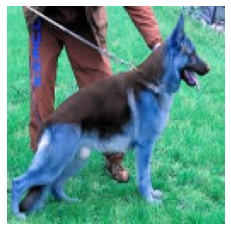

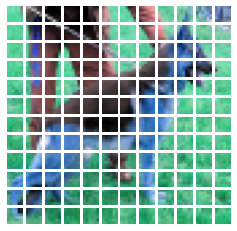

In [ ]:
display_patches(dog_X_train)

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


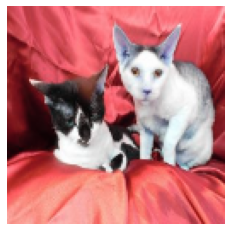

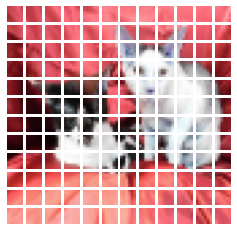

In [ ]:
display_patches(cat_X_train)

# Implement the patch encoding layer

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier(input_shape, data_augmentation, num_classes):
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def run_experiment(model, X_train, y_train, X_test, y_test):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=  X_train,
        y= y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [ ]:
cat_vit_classifier = create_vit_classifier(cat_input_shape,cat_data_augmentation,cat_num_classes )
cat_history = run_experiment(cat_vit_classifier, cat_X_train, cat_y_train, cat_X_test, cat_y_test)

Epoch 1/100
2386/2386 [==============================] - 77s 29ms/step - loss: 2.7994 - accuracy: 0.4114 - top-5-accuracy: 0.5683 - val_loss: 2.6252 - val_accuracy: 0.4181 - val_top-5-accuracy: 0.5946
Epoch 2/100
2386/2386 [==============================] - 68s 29ms/step - loss: 2.6353 - accuracy: 0.4198 - top-5-accuracy: 0.5893 - val_loss: 2.6047 - val_accuracy: 0.4181 - val_top-5-accuracy: 0.6108
Epoch 3/100
2386/2386 [==============================] - 69s 29ms/step - loss: 2.6102 - accuracy: 0.4197 - top-5-accuracy: 0.6008 - val_loss: 2.5887 - val_accuracy: 0.4181 - val_top-5-accuracy: 0.6029
Epoch 4/100
2386/2386 [==============================] - 69s 29ms/step - loss: 2.5856 - accuracy: 0.4198 - top-5-accuracy: 0.6095 - val_loss: 2.5629 - val_accuracy: 0.4181 - val_top-5-accuracy: 0.6181
Epoch 5/100
2386/2386 [==============================] - 69s 29ms/step - loss: 2.5682 - accuracy: 0.4199 - top-5-accuracy: 0.6192 - val_loss: 2.5442 - val_accuracy: 0.4190 - val_top-5-accuracy: 0.

In [ ]:
dog_vit_classifier = create_vit_classifier(dog_input_shape,dog_data_augmentation,dog_num_classes )
dog_history = run_experiment(dog_vit_classifier, dog_X_train, dog_y_train, dog_X_test, dog_y_test)